### Load the needed modules

In [2]:
import pandas as pd
import numpy as np
import copy
import warnings
from itertools import islice 

# To filter out all warnings (not recommended)
warnings.filterwarnings("ignore")

# Machine Learning Tasks
from sklearn.metrics import roc_curve, auc, make_scorer, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb, xgboost as xgb
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import time

# Confidence Interval
# auc_delong_xu is a series of functions for calculating AUC comparisons, 
# created by yandexdataschool and adapted by RaulSanchezVasquez to calculate confidence intervals that gives the same results as pROC in R
# can be downloaded from: https://github.com/RaulSanchezVazquez/roc_curve_with_confidence_intervals/blob/master/README.md
from auc_delong_xu import auc_ci_Delong

# Explainable AI
import shap

# Diet-Met Correlation and Heatmaps
import pingouin as pg
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
import matplotlib as mpl
import seaborn as sns

### Load saved variables
Use, if you want to save time in running the classifiers, and skip to other aspects of the code

In [4]:
store -r

### Read in the data

In [9]:
file_path = ["../R Processed Data/BB_imp_sc_trans_filt_label.csv", 
             "../R Processed Data/HMP_imp_sc_trans_filt_label.csv"]

X_list = []
y_list = []
X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []


for dataset_id in range(len(file_path)):
    X = pd.read_csv(file_path[dataset_id], index_col=0).sort_index()
    y = X['Label']
    y = y.replace({'IBD': 1, 'nonIBD': 0})
    X = X.drop('Label', axis=1)
#     if dataset_id == 1:
#         X = X.drop('NUA', axis=1)
    
    ### TRAIN TEST SPLIT ###
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=True, stratify = y, random_state=42)
    
#     ## TRAIN TEST SPLIT ### for when we want to signficantly reduce sample size to test classifier changes
#     X_train, X_test, y_train, y_test = train_test_split(
#        X_train, y_train, test_size=0.2, shuffle=True, stratify = y_train, random_state=42)
    
    X_list.append(X)
    y_list.append(y)
    X_train_list.append(X_train)
    y_train_list.append(y_train)
    X_test_list.append(X_test)
    y_test_list.append(y_test)

In [10]:
file_name = ["UKBB (plasma)",
             "HMP2 (feces)"]

model_name = ["XGB",
              "LGBM",
              "RF",
              "LASSO"]

In [7]:
param_grids = {
    'xgb': {
        'n_estimators': list(range(100, 500, 100)),
        'max_depth': [5, 10, 20, 30],
        'learning_rate': [0.1, 0.01, 0.05],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    },
    'lgb': {
        'num_leaves': [31, 63, 127],
        'max_depth': [5, 10, 20, 30],
        'learning_rate': [0.1, 0.01, 0.05],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    },
    'rf': {
        'n_estimators': list(range(100, 500, 100)),
        'max_depth': [5, 10, 20, 30],
        'max_samples': [0.8, 1.0], 
        'max_features': ['sqrt', 0.3, 0.5, 1.0],
        'criterion': ['gini', 'entropy']
    },
    'lasso': {
#         'C': list(np.logspace(-3,3,7))
        'alpha': list(np.logspace(-3,3,7))
    }
}

models = {
    'xgb': xgb.XGBClassifier(objective = 'binary:logistic', seed=42),
    'lgb': lgb.LGBMClassifier(objective='binary', seed=42),
    'rf': RandomForestClassifier(random_state=42),
#     'lasso': LogisticRegression(penalty='l1', max_iter=10000, solver='liblinear', class_weight='balanced', random_state=42)
    'lasso': Lasso(random_state=42, max_iter=10000)
}

classifier_data = {
    'xgb': {
        'grid_best_mscore': None,
        'grid_best_std': None,
        'classifier': None,
        'fpr': None,
        'tpr': None,
        'auc_score': None,
        'y_pred_prob': None
    },
    'lgb': {
        'grid_best_mscore': None,
        'grid_best_std': None,
        'classifier': None,
        'fpr': None,
        'tpr': None,
        'auc_score': None,
        'y_pred_prob': None
    },
    'rf': {
        'grid_best_mscore': None,
        'grid_best_std': None,
        'classifier': None,
        'fpr': None,
        'tpr': None,
        'auc_score': None,
        'y_pred_prob': None,
    },
    'lasso': {
        'grid_best_mscore': None,
        'grid_best_std': None,
        'classifier': None,
        'fpr': None,
        'tpr': None,
        'auc_score': None,
        'y_pred_prob': None
    }
}

dataset_classifier_data = {}

## Model Optimization

In [8]:
for dataset_id in range(len(file_path)):
    print(file_name[dataset_id])
    print("="*60)
    print()

    for i, classifier in enumerate(classifier_data):
        print(model_name[i])    

        base_model = models[classifier] 
        param_grid = param_grids[classifier]

        scorer = make_scorer(roc_auc_score, needs_threshold=True)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # retrieve the train and test data
        X_train = X_train_list[dataset_id]
        y_train = y_train_list[dataset_id]
        X_test = X_test_list[dataset_id]
        y_test = y_test_list[dataset_id]

        # start recording the time for grid search to run
        time_start = time.time()

        # run grid search
        grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, 
                                   scoring=scorer, refit=find_best_index_,
                                   cv=skf, n_jobs=-1)

        grid_search.fit(X_train.values, y_train)

        # stop recording
        time_grid = time.time() - time_start

        best_grid_model = grid_search.best_estimator_
        best_grid_model_params = grid_search.best_params_
        best_idx = np.argsort(grid_search.cv_results_['mean_test_score'])[-1]
        best_grid_model_score = grid_search.cv_results_['mean_test_score'][best_idx]
        best_grid_model_std = grid_search.cv_results_['std_test_score'][best_idx]

        print(f"Grid Search took {time_grid/60:.2f} mins ({time_grid:.2f} secs)")
        print(f"Best parameters: {best_grid_model_params}")
        print(f"Grid Validation AUC score: {best_grid_model_score}")
        print(f"Grid Validation std: {best_grid_model_std}")

        classifier_data[classifier]['classifier'] = best_grid_model
        classifier_data[classifier]['grid_best_mscore']: best_grid_model_score
        classifier_data[classifier]['grid_best_std']: grid_search.cv_results_['std_test_score'][best_idx]

        # predict and evaluate model performance (AUC)
        y_pred_prob = best_grid_model.predict(X_test.values) if i == 3 else best_grid_model.predict_proba(X_test.values)[:,1]
        classifier_data[classifier]['y_pred_prob'] = y_pred_prob
        fpr_num, tpr_num, _ = roc_curve(y_test, y_pred_prob)
        classifier_data[classifier]['fpr'] = fpr_num
        classifier_data[classifier]['tpr'] = tpr_num
        auc_score_num = auc(fpr_num, tpr_num)
        classifier_data[classifier]['auc_score'] = auc_score_num
        
        # Calculate other performance metrics
        true_labels = y_test.values
        predicted_labels = best_grid_model.predict(X_test.values)
        # when the classifier == 'lasso' (i == 3),
        # lasso does not have the same output as the other classifiers
        # so, we calculate lasso prediction based on the probab values
        if i == 3: 
            # Apply 0.5 threshold to classify as 1 or 0
            predicted_labels = np.where(y_pred_prob >= 0.5, 1, 0)
        confusion = confusion_matrix(true_labels, predicted_labels)
        TP = confusion[1, 1]
        TN = confusion[0, 0]
        FP = confusion[0, 1]
        FN = confusion[1, 0]
        specificity = TN / (TN + FP)
        recall = recall_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels)
        f1 = f1_score(true_labels, predicted_labels)
        balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)

        alpha=.95
        # calculate AUC score confidence interval
        auc_delong, auc_variance, ci = auc_ci_Delong(y_true=true_labels, y_scores=y_pred_prob, alpha=alpha)

        # print results
        print("Test AUC score: ", auc_score_num)
        print(f"{alpha*100} % AUC CI: {ci}")
        print("Specificity:", specificity)
        print("Sensitivity (Recall):", recall)
        print("Precision:", precision)
        print("F1 Score:", f1)
        print("Balanced Accuracy:", balanced_accuracy)
        print("-"*40)
        
    dataset_classifier_data[file_name[dataset_id]] = copy.deepcopy(classifier_data)
    print()

UKBB (plasma)

XGB
Grid Search took 22.64 mins (1358.64 secs)
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Grid Validation AUC score: 0.6460265566975825
Grid Validation std: 0.022477284295198928
Test AUC score:  0.674746719249337
95.0 % AUC CI: [0.62455681 0.72493663]
Specificity: 0.9685863874345549
Sensitivity (Recall): 0.17532467532467533
Precision: 0.6923076923076923
F1 Score: 0.27979274611398963
Balanced Accuracy: 0.5719555313796152
----------------------------------------
LGBM
Grid Search took 1.34 mins (80.50 secs)
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 31, 'subsample': 0.8}
Grid Validation AUC score: 0.639756515694376
Grid Validation std: 0.02577270501952031
Test AUC score:  0.6758686339838172
95.0 % AUC CI: [0.62530314 0.72643412]
Specificity: 0.9633507853403142
Sensitivity (Recall): 0.22727272727272727
Precision: 0.7142857142857143
F1 Score: 0.34

In [9]:
%store dataset_classifier_data

Stored 'dataset_classifier_data' (dict)


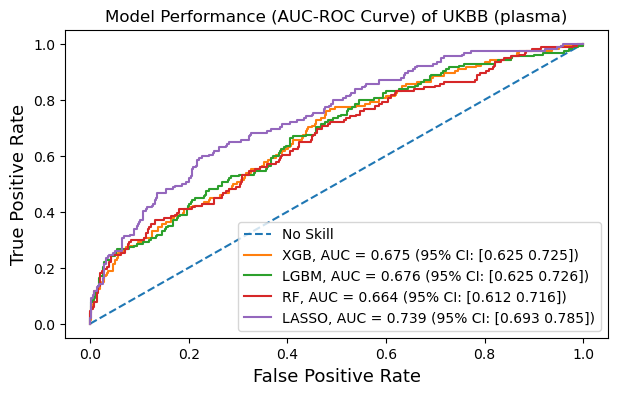

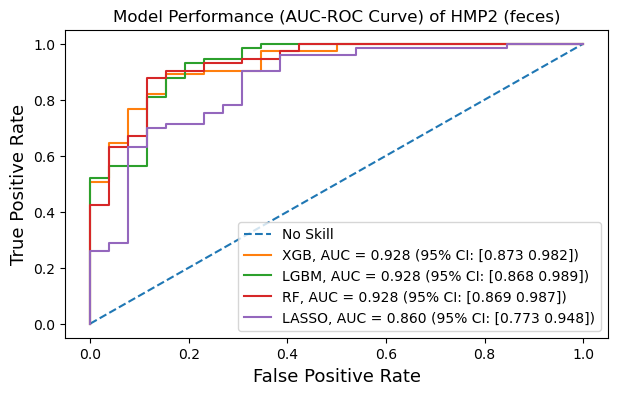

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# generate for No SKill
ns_probs = [0 for _ in range(len(y_test_list[1]))]
ns_auc = roc_auc_score(y_test_list[1], ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test_list[1], ns_probs)

for i, dataset in enumerate(file_name):
    plt.figure(figsize=(7, 4))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    y_test = y_test_list[i]
    for j, classifier in enumerate(dataset_classifier_data[dataset]):
        cf_data = dataset_classifier_data[dataset][classifier]
        y_pred_prob = cf_data['y_pred_prob']
        # calculate the AUC CI
        auc_delong, auc_variance, ci = auc_ci_Delong(y_true=true_labels, y_scores=y_pred_prob, alpha=.95)
        plt.plot(cf_data['fpr'], cf_data['tpr'], label='{}, AUC = {:.3f} (95% CI: {})'.format(model_name[j], cf_data['auc_score'], np.round(ci,3)))
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title(f'Model Performance (AUC-ROC Curve) of {file_name[i]}', size=12)
    plt.legend()
    plt.savefig(f'Python Processed Data/ML and XAI/AUC-ROC Curve of {file_name[i]}.png')
    plt.show()

## Choosing the best classifier for each dataset

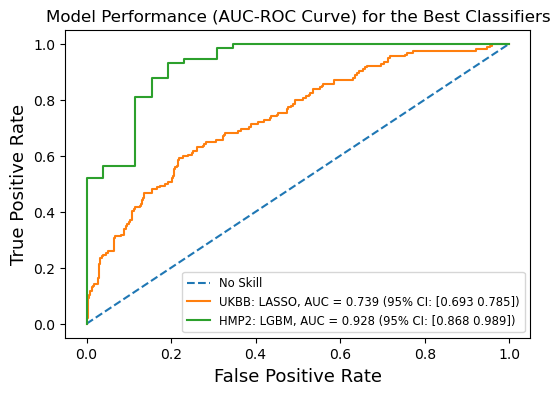

In [15]:
plt.figure(figsize=(6, 4))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')

dataset_short = ['UKBB', 'HMP2']

for i, dataset in enumerate(file_name):
    classifiers = ['xgb', 'lgb', 'rf', 'lasso']
    best_classifier = None
    best_score = float('-inf')
    y_test = y_test_list[i]
    # Find the classifier with the highest auc_score or choose xgb if both scores are equal
    for classifier in classifiers:
        score = dataset_classifier_data[dataset][classifier]['auc_score']
        if score > best_score:
            best_score = score
            best_classifier = classifier   
        elif score == best_score:
            # Priority: lgb (performed better in other parameters in hmp2) > rf > xgb > lasso
            if classifier == 'lgb':
                best_classifier = classifier
            elif classifier == 'rf' and best_classifier != 'lgb':
                best_classifier = classifier
            elif classifier == 'xgb' and best_classifier not in ['rf', 'lgb']:
                best_classifier = classifier
            elif classifier == 'lasso' and best_classifier not in ['rf', 'lgb', 'xgb']:
                best_classifier = classifier
    cf_data = dataset_classifier_data[dataset][best_classifier]
    y_pred_prob = cf_data['y_pred_prob']
    # calculate the AUC CI
    auc_delong, auc_variance, ci = auc_ci_Delong(y_true=true_labels, y_scores=y_pred_prob, alpha=alpha)
    # to change the display names of the classifiers 
    # lgb to LGBM, rf to RF etc.
    if best_classifier == 'lgb':
        plt.plot(cf_data['fpr'], cf_data['tpr'], label='{}: LGBM, AUC = {:.3f} (95% CI: {})'.format(dataset_short[i], cf_data['auc_score'], np.round(ci,3)))
    else:
        plt.plot(cf_data['fpr'], cf_data['tpr'], label='{}: {}, AUC = {:.3f} (95% CI: {})'.format(dataset_short[i], best_classifier.upper(), cf_data['auc_score'], np.round(ci,3)))
plt.xlabel('False Positive Rate', size=13)
plt.ylabel('True Positive Rate', size=13)
plt.title(f'Model Performance (AUC-ROC Curve) for the Best Classifiers', size=12)
plt.legend(fontsize='small')
plt.savefig(f'Python Processed Data/ML and XAI/AUC-ROC Curve for the Best Classifiers.png')
plt.show()

------------
## Explainable AI: SHAP

In [23]:
shap_dataset_classifier_data = {}
import shap
# Calculate SHAP values
for i, dataset in enumerate(file_name):
    classifiers = ['xgb', 'lgb', 'rf','lasso']
    best_classifier = None
    best_score = float('-inf')
     
    # Find the classifier with the highest auc_score or choose xgb if both scores are equal
    for classifier in classifiers:
        score = dataset_classifier_data[dataset][classifier]['auc_score']
        if score > best_score:
            best_score = score
            best_classifier = classifier
        elif score == best_score:
            # Priority: lgb (performed better in other parameters) in hmp2> rf > xgb > lasso
            if classifier == 'lgb':
                best_classifier = classifier
            elif classifier == 'rf' and best_classifier != 'lgb':
                best_classifier = classifier
            elif classifier == 'xgb' and best_classifier not in ['rf', 'lgb']:
                best_classifier = classifier
            elif classifier == 'lasso' and best_classifier not in ['rf', 'lgb', 'xgb']:
                best_classifier = classifier
        
    print(dataset)
    print(best_classifier)
    print()
    
    cf_data = dataset_classifier_data[dataset][best_classifier]
    if best_classifier == 'rf':
        explainer = shap.Explainer(cf_data['classifier'])  
    elif best_classifier == 'lasso':
        masker = shap.maskers.Independent(data = X_test_list[i])
        explainer = shap.LinearExplainer(cf_data['classifier'], masker=masker)  
    elif best_classifier == 'lgb':
        explainer = shap.TreeExplainer(cf_data['classifier'])
        if isinstance(cf_data['classifier'], lgb.LGBMClassifier):
             explainer.model.original_model.params['objective'] = 'binary'
    else: 
        explainer = shap.TreeExplainer(cf_data['classifier'])
        
    # initialize it as an empty dictionary first, before adding to it
    shap_dataset_classifier_data.setdefault(dataset, {})
    shap_dataset_classifier_data[dataset].setdefault(best_classifier, {})
    
    shap_dataset_classifier_data[dataset][best_classifier]['explainer'] = explainer
    dataset_classifier_data[dataset][best_classifier]['explainer'] = explainer
    
    shap_values = explainer.shap_values(X_test_list[i])
    shap_dataset_classifier_data[dataset][best_classifier]['shap_values'] = shap_values
    dataset_classifier_data[dataset][best_classifier]['shap_values'] = shap_values
    
    if best_classifier == 'lasso':
        shap_values_df = pd.DataFrame(shap_values, columns=X_test_list[i].columns, index=X_test_list[i].index)
    else: 
        shap_values_df = pd.DataFrame(shap_values[i], columns=X_test_list[i].columns, index=X_test_list[i].index) # 1 for the positive class, IBD
    shap_dataset_classifier_data[dataset][best_classifier]['shap_values_df'] = shap_values_df
    dataset_classifier_data[dataset][best_classifier]['shap_values_df'] = shap_values_df

UKBB (plasma)
lasso

HMP2 (feces)
lgb



In [24]:
# Finding the top features

selected_features_list = []

for dataset in file_name:
    for classifier, shap_data in shap_dataset_classifier_data[dataset].items():
        if 'shap_values_df' in shap_data:
            print(classifier)
            shap_values_df = shap_dataset_classifier_data[dataset][classifier]['shap_values_df']
            shap_values_df_normalized = shap_values_df.div(shap_values_df.sum().sum())


    # Calculate the mean of absolute values for each column
    abs_mean_values = np.abs(shap_values_df).mean()

    # Initialize variables
    total_contribution = 0
    selected_features = []
    bottom_features = []

    # Sort the features by absolute mean values in descending order
    sorted_features = abs_mean_values.sort_values(ascending=False)

    # selecting the top 20 features
    selected_features = sorted_features[:20].index.values
    total_contribution = sorted_features[:20].values.sum()

    # Calculate the top-bottom ratio
    count = len(selected_features)
    bottom_features = abs_mean_values.nsmallest(count).index.tolist()
    bottom_features_contribution =  abs_mean_values[bottom_features].sum() / abs_mean_values.sum()
    top_features_contribution = total_contribution / abs_mean_values.sum()
    tb_ratio = top_features_contribution / bottom_features_contribution

    # Print the selected features, their cumulative contribution, and odds ratio
    print("Selected Features:", selected_features)
    print("Number of Features:", len(selected_features))
    print("% of Total Features:", count/len(abs_mean_values)*100)
    print("Cumulative Contribution of Top Features:", top_features_contribution)
    print("Cumulative Contribution of Bottom Features:", bottom_features_contribution)
    print("Ratio of Top to Bottom Features:", tb_ratio)
    print()
    
    selected_features_list.append(selected_features)

lasso
Selected Features: ['GlycA' 'S-LDL-FC' 'Albumin' 'Omega-3' 'XXL-VLDL-TG' 'Glycine' 'Glucose'
 'Citrate' 'LA' 'Valine' 'IDL-TG' 'Creatinine' 'bOHbutyrate' 'XL-HDL-FC'
 'Acetoacetate' 'Phenylalanine' 'Alanine' 'Pyruvate' 'M-HDL-PL' 'Lactate']
Number of Features: 20
% of Total Features: 54.054054054054056
Cumulative Contribution of Top Features: 0.9958007610069102
Cumulative Contribution of Bottom Features: 0.022371361672262537
Ratio of Top to Bottom Features: 44.51229994826683

lgb
Selected Features: ['NUA' 'Pyridoxine' 'C18:1 LPC-P' 'N-AcPut' 'C16:0 SM' 'C36:2 PC'
 'Urobilin' 'Acetyl-GalN' 'Metformin' 'Hydroxycotinine' 'N-MePro' 'NMPC'
 'Acetaminophen' '1-MNA' 'NAM' 'Histidinol' '7-MeG' 'Cadaverine' 'Quinine'
 'Pterin']
Number of Features: 20
% of Total Features: 12.422360248447205
Cumulative Contribution of Top Features: 0.5985680230836609
Cumulative Contribution of Bottom Features: 0.007381423504072829
Ratio of Top to Bottom Features: 81.09113679135068



#### Generating the Summary Plots

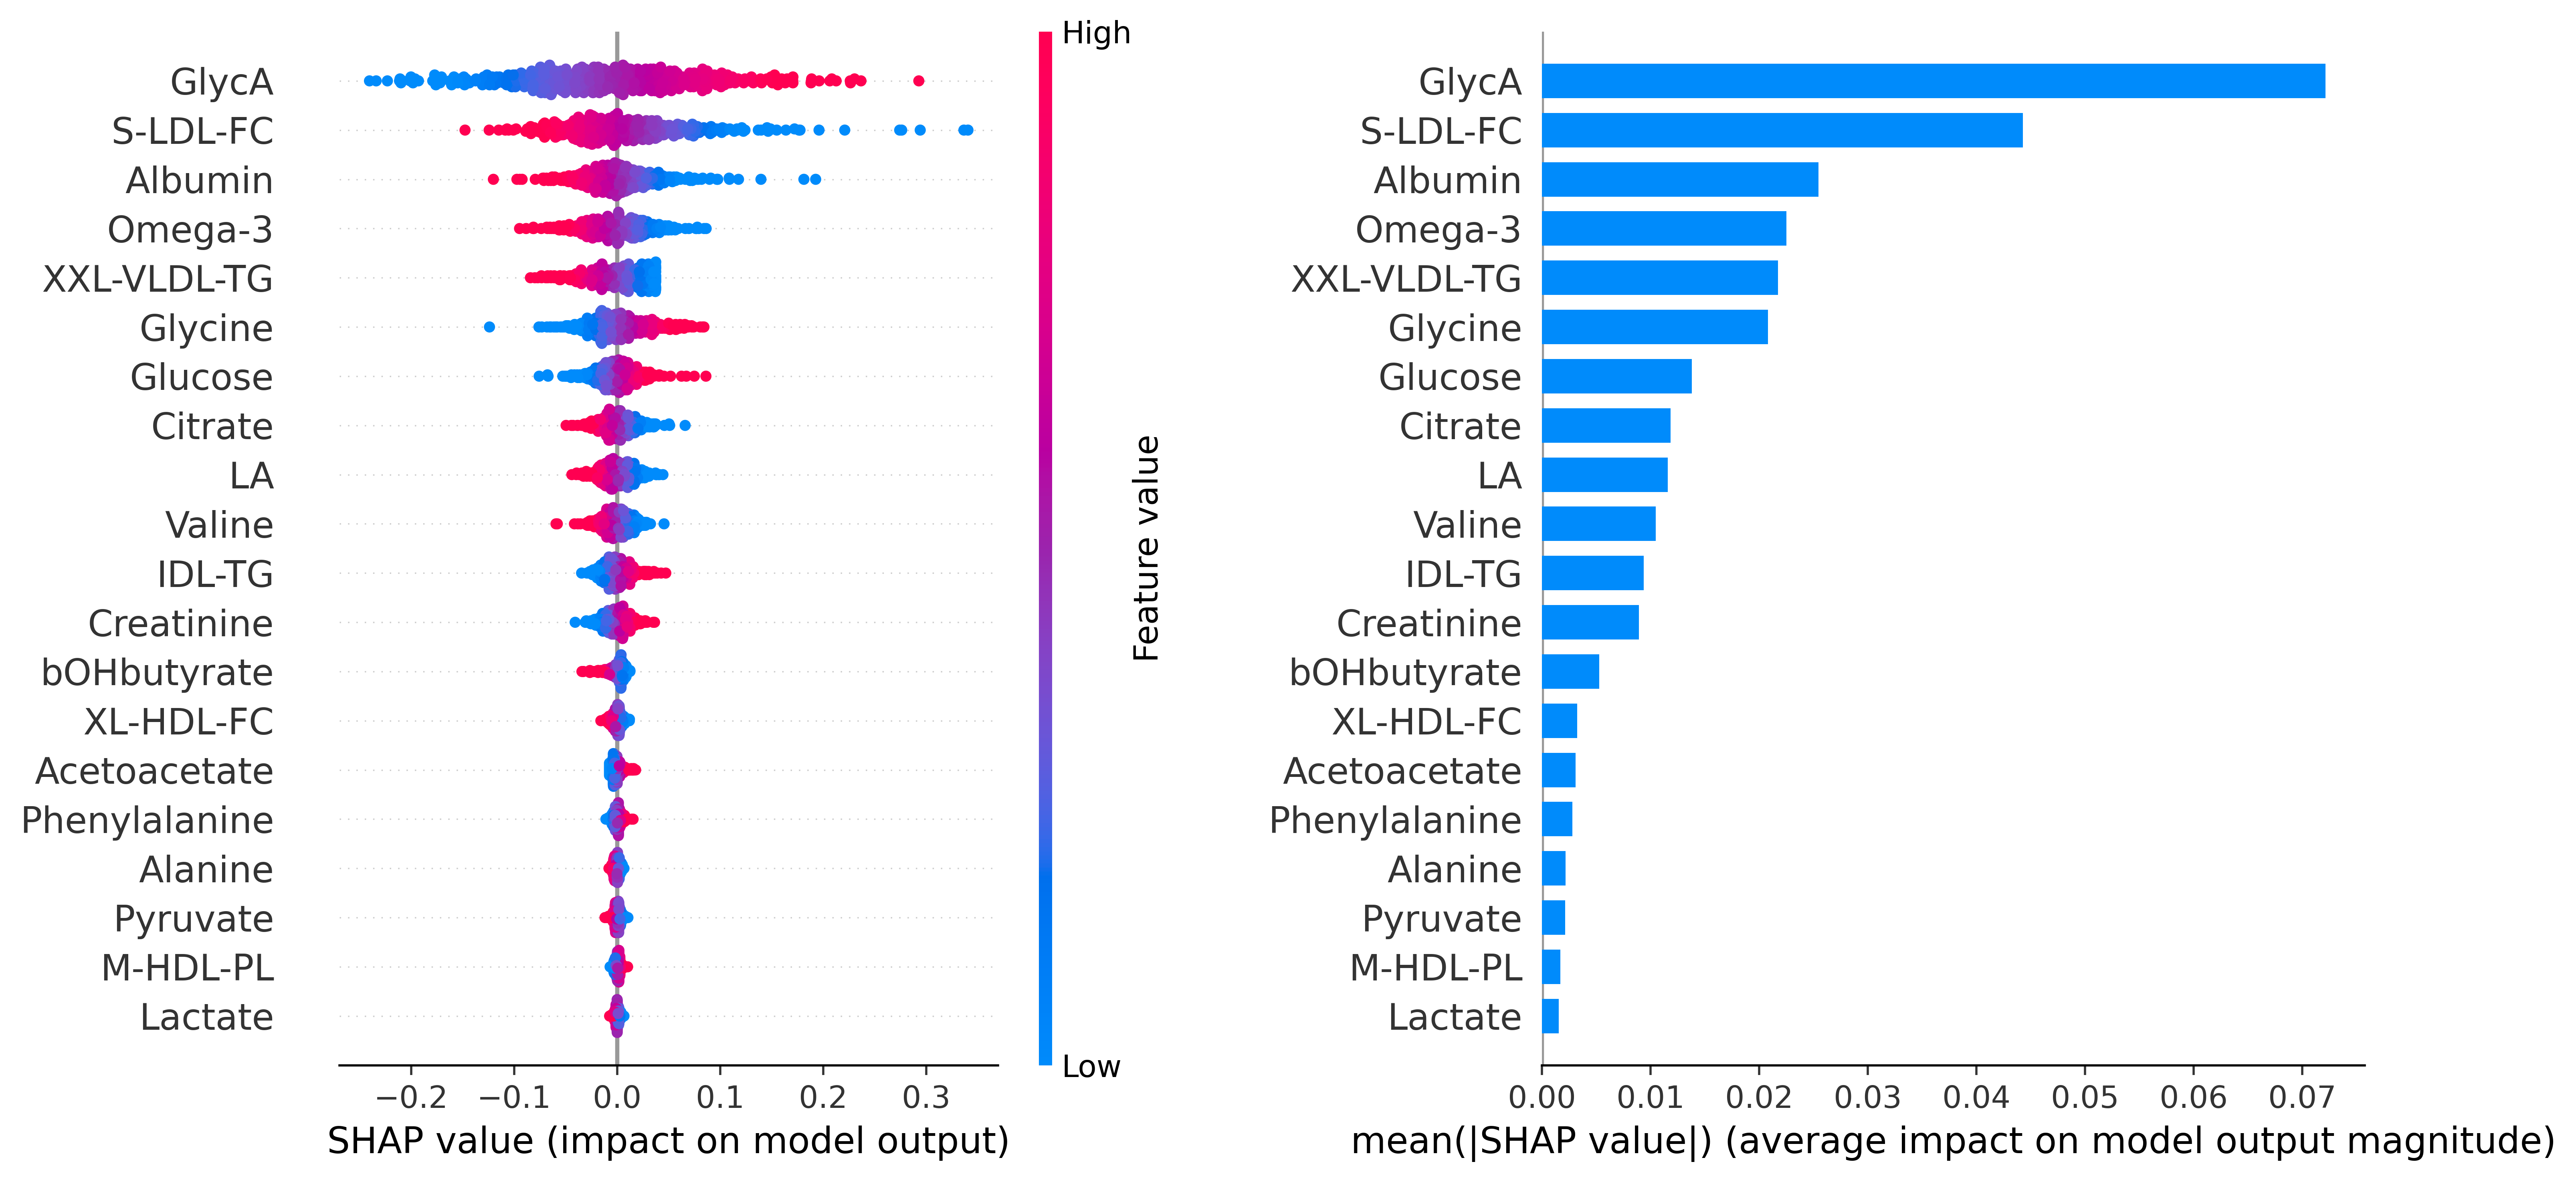

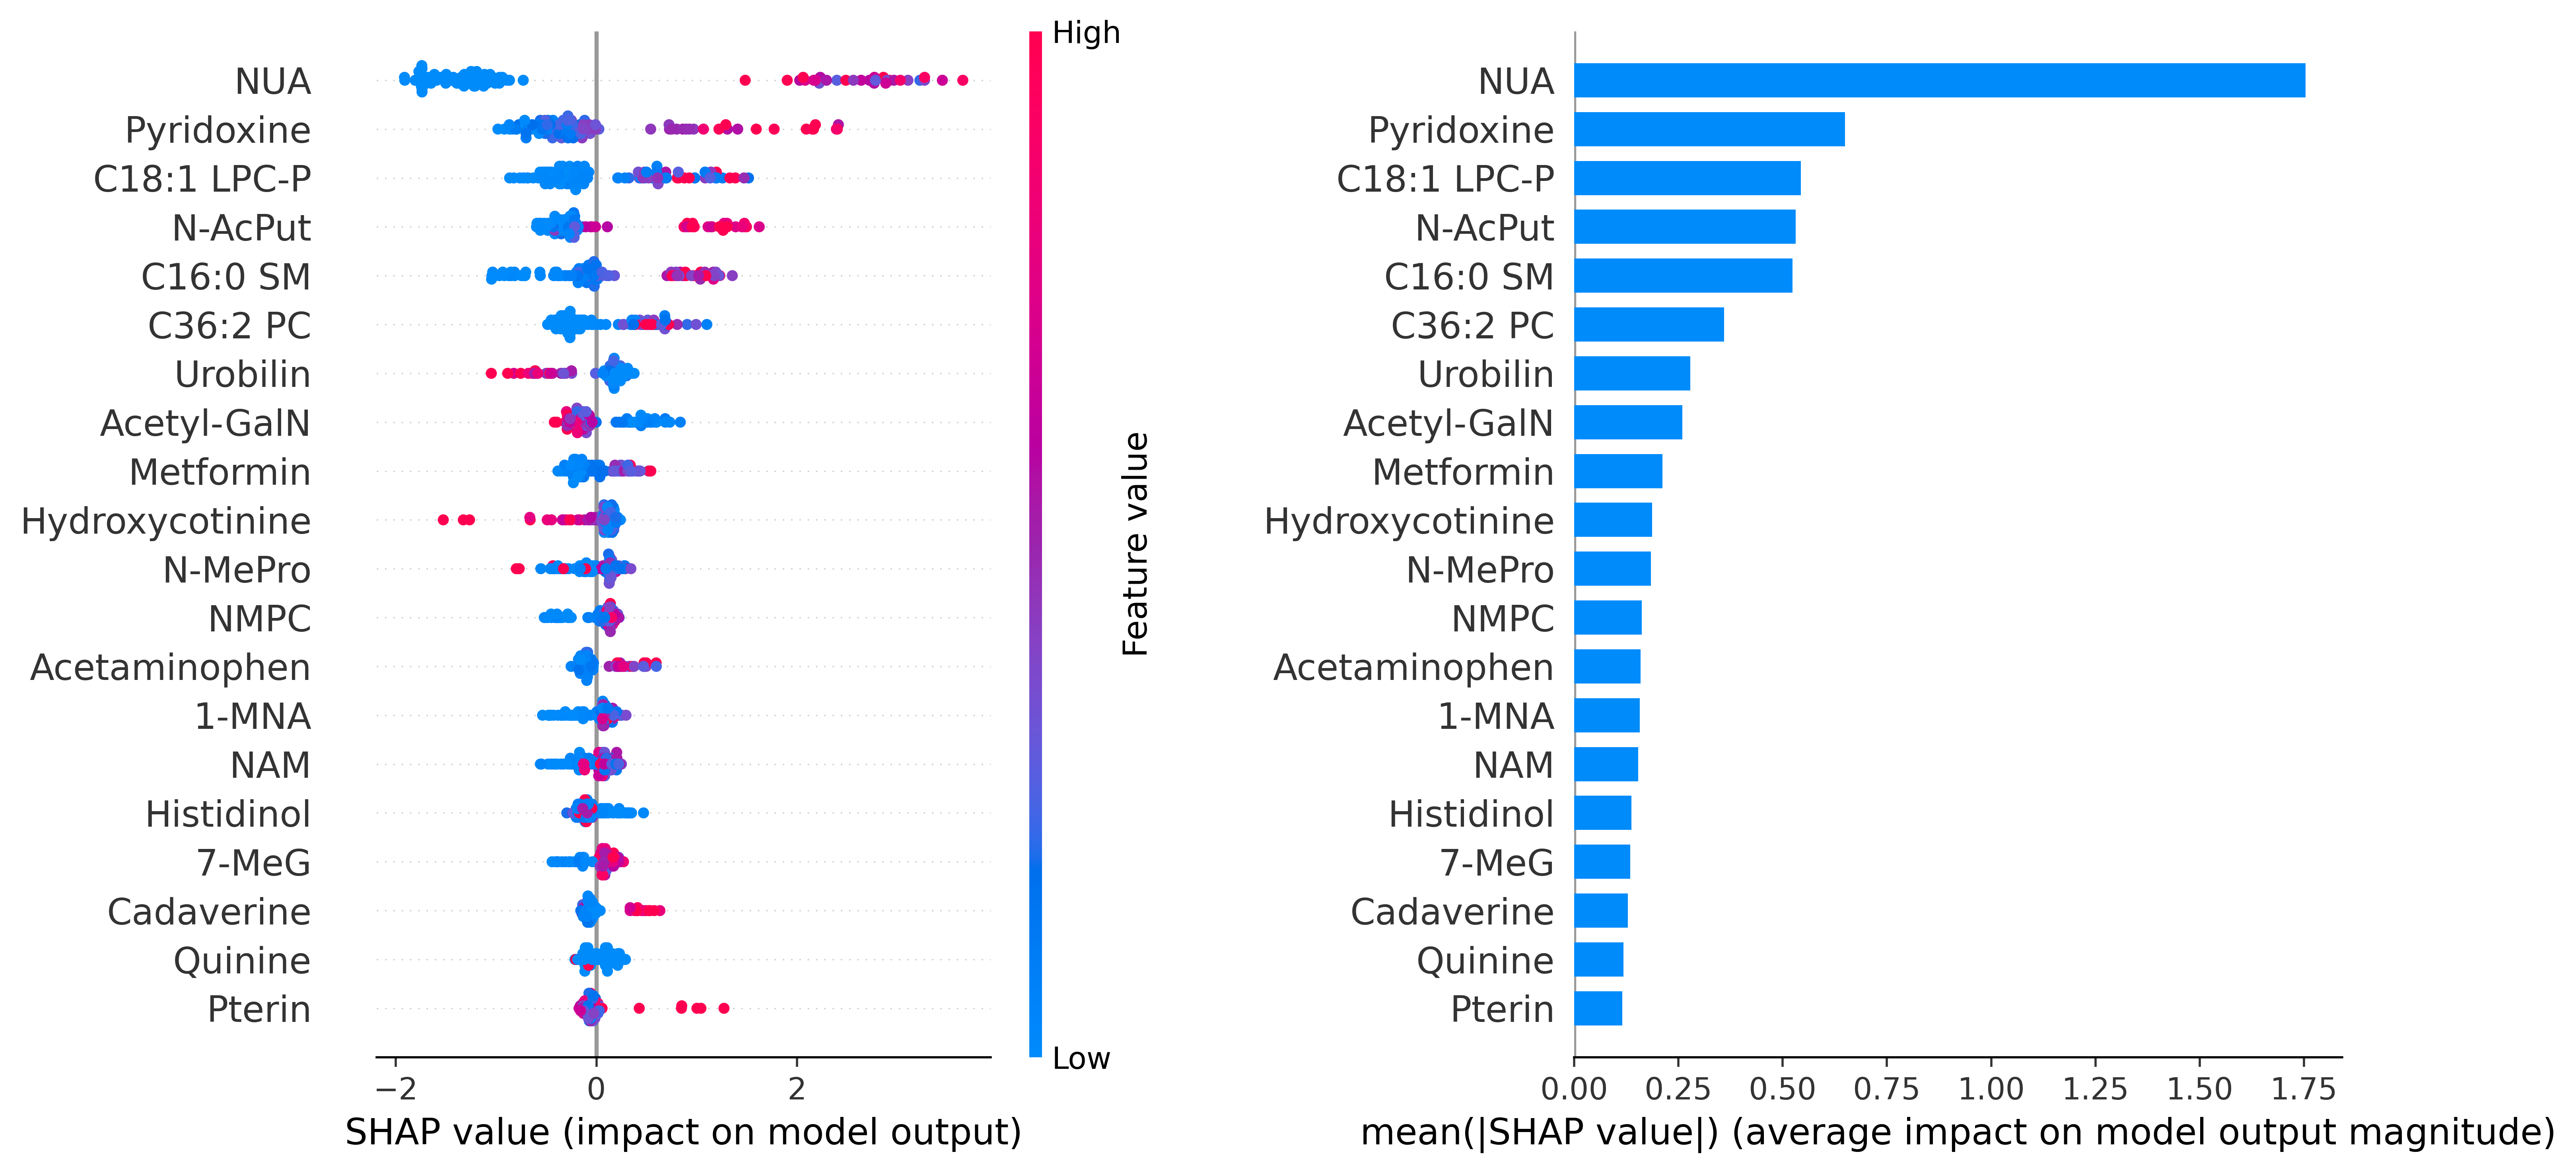

In [20]:
RankedMetaboliteData = [h for h in range(len(file_name))]

for i, dataset in enumerate(file_name):
    for classifier, shap_data in shap_dataset_classifier_data[dataset].items():
        if 'shap_values' in shap_data:
            shap_values = shap_dataset_classifier_data[dataset][classifier]['shap_values']
            shap_values_df = shap_dataset_classifier_data[dataset][classifier]['shap_values_df']
    fig = plt.figure(dpi=500)
    ax0 = fig.add_subplot(131)
    if i == 0: # when lasso is the top one 
        shap.summary_plot(shap_values, X_test_list[i], show=False, max_display=len(selected_features_list[0]), plot_type='dot')
        ax1 = fig.add_subplot(132)
        shap.summary_plot(shap_values,  X_test_list[i], show=False, max_display=len(selected_features_list[0]), plot_type='bar')
        vals= np.abs(shap_values).mean(0)
    else:
        shap.summary_plot(shap_values[1], X_test_list[i], show=False, max_display=len(selected_features_list[0]), plot_type='dot')
        vals= np.abs(shap_values[1]).mean(0)
        ax1 = fig.add_subplot(132)
        shap.summary_plot(shap_values[1],  X_test_list[i], show=False, max_display=len(selected_features_list[0]), plot_type='bar')
    plt.gcf().set_size_inches(18,6)
    plt.tight_layout() 
    # export the figures
    plt.savefig('Python Processed Data/ML and XAI/{}_summary_mean.png'.format(dataset), bbox_inches='tight')
    plt.show()
    # Export the ranked metabolites:
    import numpy as np
    feature_importance = pd.DataFrame(list(zip(X_test_list[i].columns, vals)), columns=['col_name', 'feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
    ranked_features = feature_importance['col_name'].values
    # export the original dataframe with the values but shap ranked
    RankedMetaboliteData[i] = pd.concat([y_list[i], X_list[i][ranked_features]], axis = 1)
    RankedMetaboliteData[i].to_csv(f"Python Processed Data/ML and XAI/X values Shap-Ranked for {dataset}.csv", index = True)
    # export the shap values dataframe in the shap-ranked order
    pd.concat([y_test_list[i], shap_values_df[ranked_features]], axis = 1).to_csv(f"Python Processed Data/ML and XAI/SHAP values Shap-Ranked for {dataset}.csv", index = True)

##### Store the variables

In [25]:
%store shap_dataset_classifier_data
%store dataset_classifier_data
%store selected_features_list

Stored 'shap_dataset_classifier_data' (dict)
Stored 'dataset_classifier_data' (dict)
Stored 'selected_features_list' (list)


# Diet - Metabolite Interactions

UKBB (plasma) IBD:
Total Correlations (|r| >= 0.1): 36
Total Significant Correlations: 36
lp: -0.0911, up: 0.109
Total Extreme Correlations (lp > r > up): 35

HMP2 (feces) IBD:
Total Correlations (|r| >= 0.1): 111
Total Significant Correlations: 65
lp: -0.13905, up: 0.149
Total Extreme Correlations (lp > r > up): 39



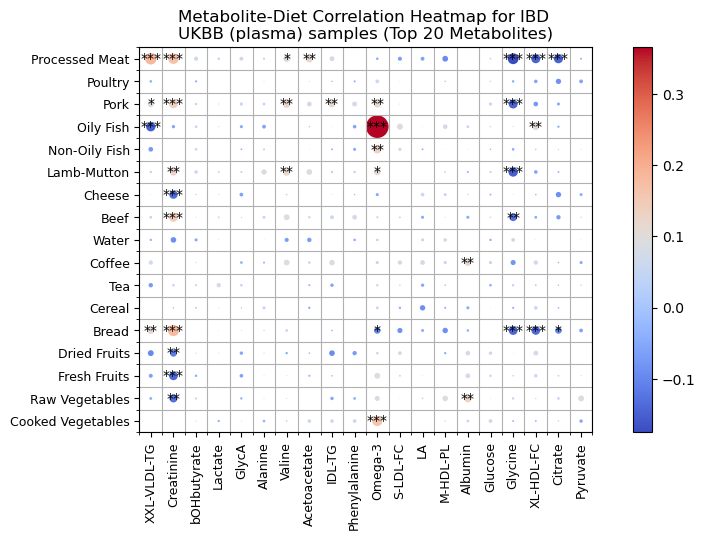

<Figure size 1000x1000 with 0 Axes>

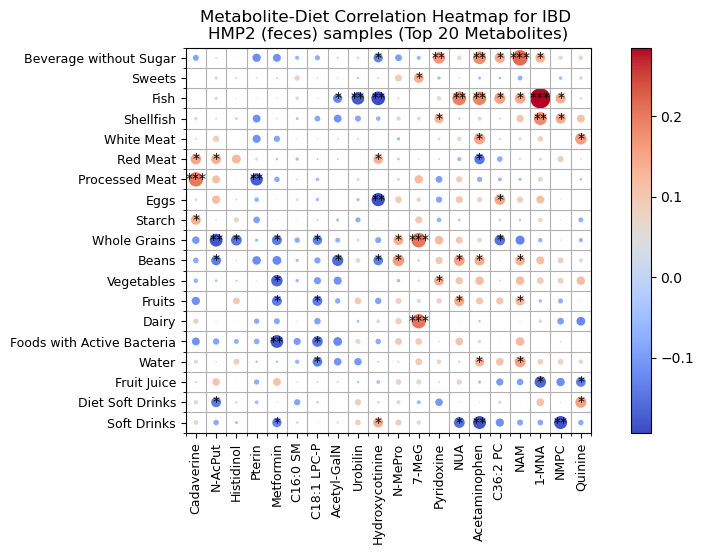

<Figure size 1000x1000 with 0 Axes>

In [8]:
# for IBD
ibd = 1 ## <- EDIT THIS TO GENERATE FIGURES FOR ONLY IBD (1), ONLY NON-IBD (0), OR BOTH (any other number)

diet_file_path = [
    "R Processed Data/BBdiet.csv",
    "R Processed Data/HMPdiet.csv"
]

SHAPmetabolite_file_path = [
    "Python Processed Data/ML and XAI/X values Shap-Ranked for UKBB (plasma).csv",
    "Python Processed Data/ML and XAI/X values Shap-Ranked for HMP2 (feces).csv"
]

file_names = ["UKBB (plasma)",
         "HMP2 (feces)"]
    
for i in range(len(file_names)):

    x = pd.read_csv(diet_file_path[i], index_col=0)
    y =  pd.read_csv(SHAPmetabolite_file_path[i], index_col=0)
    
    if ibd == 0:
        class_id = "Non-IBD"
        y = y[y['Label'] == ibd]
    elif ibd == 1:
        class_id = "IBD"
        y = y[y['Label'] == ibd]
    else:
        class_id = "All"
        
    y = y.loc[:, y.columns != 'Label']
    x = x[x.index.isin(y.index)]
    
    # only display the diet-metabolite heatmap for the top features
    y = y.iloc[:, :len(selected_features_list[0])]

    df = pd.concat([x, y], axis=1)
    
    # calculate correlation
    r = df.rcorr(method='spearman', padjust='fdr_bh').iloc[x.shape[1]:, :-y.shape[1]]
    r.T.to_csv(f"Python Processed Data/Diet-Metabolite/Correlation Table for {file_names[i]} {class_id}.csv", index=True)
    # calculate significant stars
    stars = df.rcorr(method='spearman', padjust='fdr_bh').iloc[:x.shape[1], x.shape[1]:].T
    # calculate significance
    p = df.rcorr(method='spearman', padjust='fdr_bh', stars=True, decimals = 150).iloc[:x.shape[1], x.shape[1]:].T
    p_values = df.rcorr(method='spearman', padjust='fdr_bh', stars=False, decimals = 150).iloc[:x.shape[1], x.shape[1]:].T
    p_values.T.to_csv(f"Python Processed Data/Diet-Metabolite/P-value Correlation Table for {file_names[i]} {class_id}.csv", index=True)
    # calculate p-value significance threshold
    p_threshold = 0.05 / (x.shape[1] * y.shape[1])
    
    # calculate extreme correlations (percentile-based)
    values = r.values.astype(float).flatten()
    perc = 5
    lower_percentile = np.percentile(values, perc)
    upper_percentile = np.percentile(values, 100-perc)
    
    # COUNT HOW MANY CORRELATIONS THERE ARE
    print(f"{file_names[i]} {class_id}:")
    print("Total Correlations (|r| >= 0.1):", r.astype(float)[np.abs(r.astype(float)) >= 0.1].count().sum())
    print(f"Total Significant Correlations:", p[(p.applymap(lambda x: x in ["***", "**", "*"])) & (np.abs(r.astype(float)) >= 0.1)].count().sum())
    print(f"lp: {lower_percentile}, up: {upper_percentile}")
    print("Total Extreme Correlations (lp > r > up):", r.astype(float)[(r.astype(float) >= upper_percentile) | (r.astype(float) <= lower_percentile)].count().sum())
#     print("Total Significant Extreme Correlations:", p[(p.applymap(lambda x: x in ["***", "**", "*"])) & ((r.astype(float) >= upper_percentile) | (r.astype(float) <= lower_percentile))].count().sum())
    print()
    
    # --------------------------------------------------------------
    
    # PLOT THE HEATMAP
    
    w, h, f, fr, fc = 13, 5, 13, 9, 9 # width, height, fontsize, fontsize_row, fontsize_col for 
    file_name_map = f"\n {file_names[i]}" # file name for the heatmap

    # Create a plot
    fig, ax = plt.subplots(figsize=(w, h))
    
    # codes below adapted from Ryan Neff: https://gist.github.com/ryananeff/d9824f810d185a2b6e49722de1cc5838 ------
    #----------------------------
    input_colors = r
    row_cluster = True # cluster the metabolites only
    col_cluster = False
    
    # cluster rows or cols by the degree of correlation (input_colors)
    clustergrid = sns.clustermap(input_colors.astype(float),cmap="RdBu_r",
                                row_cluster=row_cluster,col_cluster=col_cluster, method="ward")
    row_order = clustergrid.dendrogram_row.reordered_ind if row_cluster else range(len(input_colors.index))
    col_order = clustergrid.dendrogram_col.reordered_ind if col_cluster else range(len(input_colors.columns))
    
    # re-order the correlation and significance dataframes
    input_colors = input_colors.iloc[row_order,col_order]
    p_ordered = p.iloc[row_order,col_order]
    
    # clears the current figure to prepare for new visualizations
    plt.clf()
    
    N, M = input_colors.shape # N is number of rows (metabolites), M is the number of columns (food groups)
    row_labels = list(input_colors.index)
    col_labels = list(input_colors.columns)

    # x corresponds to food groups, y corresponds to metabolites
    x, y = np.meshgrid(np.arange(M), np.arange(N))
    
    # find the max value to set the maximum circle size for the map
    max_value = input_colors.astype(float).abs().max().max()
    circle_sizes = (input_colors.astype(float).abs() / max_value / 2).values # s
    colors = input_colors.astype(float).values # the colors would vary according to r

    # create the circles and add to the plot; sizes and color vary with data, 
    # patchcollection adds the circles to the map
    R = circle_sizes.flatten() 
    circles = [plt.Circle((j, i), radius=r) for r, i, j in zip(R, x.flat, y.flat)]
    col = PatchCollection(circles, array=colors.flatten(), cmap="coolwarm", norm=mpl.colors.Normalize(vmin=colors.min().min(), vmax=colors.max().max()))
    ax.add_collection(col)
    ax.set_aspect('equal') # Set the aspect ratio to equal for circles to appear properly

    # Customize the ticks and labels
    ax.set(xticks=np.arange(N), yticks=np.arange(M))
    ax.set_xticks(np.arange(N + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(M + 1) - 0.5, minor=True)
    ax.set_xticklabels(row_labels, fontsize=fc, rotation=90)
    ax.set_yticklabels(col_labels, fontsize=fr)
    ax.grid(which='minor')
    # --------------- code adaptation ended
    
    # make the bar aspect ratio proportionate to the map
    im_ratio = input_colors.shape[0]/input_colors.shape[1]
    fig.colorbar(col, fraction=0.046*im_ratio, pad=0.04)
    
    # PLOT THE HEATMAP
    for r, row in enumerate(input_colors.values):
        for s, star in enumerate(row):
            # add stars to the plot if correlation > 0.1
            if abs(float(input_colors.iloc[r,s])) >= 0.1:
                ax.text(r, s, p_ordered.iloc[r, s], va='center', ha='center', color='black', fontsize=10)
#             # indicate extremeness of value
#             if float(input_colors.iloc[r,s]) > upper_percentile or float(input_colors.iloc[r, s]) < lower_percentile:
#                 ax.text(r, s, '+', va='top', ha='center', color='black', fontsize=10)
    ax.set_title(f"Metabolite-Diet Correlation Heatmap for {class_id} \n{file_names[i]} samples (Top 20 Metabolites)", fontsize=12)
    ax.get_figure().savefig(f"Python Processed Data/Diet-Metabolite/{file_names[i]}_{class_id}_Correlation Heatmap Plot.png",
                dpi=600, bbox_inches='tight')
    
    ax.get_figure().show()

UKBB (plasma) Non-IBD:
Total Correlations (|r| >= 0.1): 32
Total Significant Correlations: 32
lp: -0.0941, up: 0.09415000000000004
Total Extreme Correlations (lp > r > up): 34

HMP2 (feces) Non-IBD:
Total Correlations (|r| >= 0.1): 159
Total Significant Correlations: 22
lp: -0.2242, up: 0.1914500000000001
Total Extreme Correlations (lp > r > up): 38



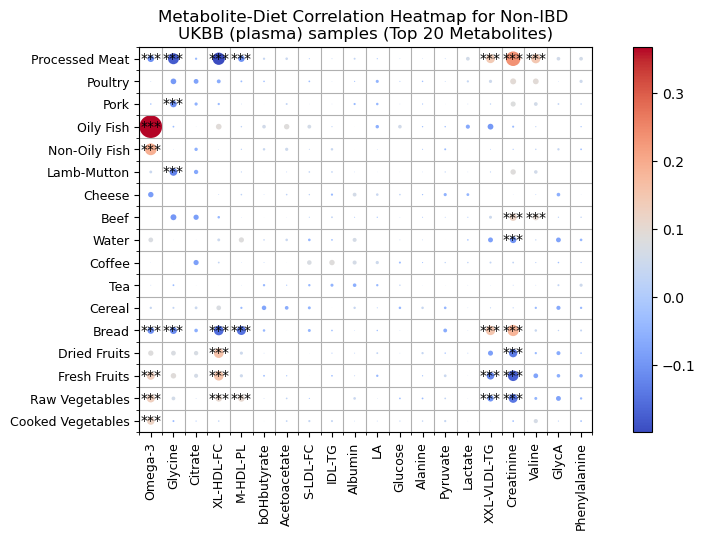

<Figure size 1000x1000 with 0 Axes>

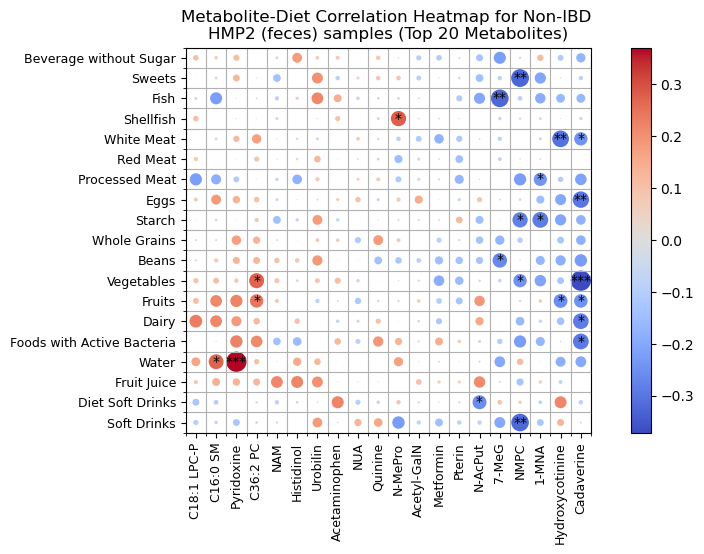

<Figure size 1000x1000 with 0 Axes>

In [9]:
# for Non-IBD
ibd = 0 ## <- EDIT THIS TO GENERATE FIGURES FOR ONLY IBD (1), ONLY NON-IBD (0), OR BOTH (any other number)

diet_file_path = [
    "R Processed Data/BBdiet.csv",
    "R Processed Data/HMPdiet.csv"
]

SHAPmetabolite_file_path = [
    "Python Processed Data/ML and XAI/X values Shap-Ranked for UKBB (plasma).csv",
    "Python Processed Data/ML and XAI/X values Shap-Ranked for HMP2 (feces).csv"
]

file_names = ["UKBB (plasma)",
         "HMP2 (feces)"]
    
for i in range(len(file_names)):

    x = pd.read_csv(diet_file_path[i], index_col=0)
    y =  pd.read_csv(SHAPmetabolite_file_path[i], index_col=0)
    
    if ibd == 0:
        class_id = "Non-IBD"
        y = y[y['Label'] == ibd]
    elif ibd == 1:
        class_id = "IBD"
        y = y[y['Label'] == ibd]
    else:
        class_id = "All"
        
    y = y.loc[:, y.columns != 'Label']
    x = x[x.index.isin(y.index)]
    
    # only display the diet-metabolite heatmap for the top features
    y = y.iloc[:, :len(selected_features_list[0])]

    df = pd.concat([x, y], axis=1)
    
    # calculate correlation
    r = df.rcorr(method='spearman', padjust='fdr_bh').iloc[x.shape[1]:, :-y.shape[1]]
    r.T.to_csv(f"Python Processed Data/Diet-Metabolite/Correlation Table for {file_names[i]} {class_id}.csv", index=True)
    # calculate significant stars
    stars = df.rcorr(method='spearman', padjust='fdr_bh').iloc[:x.shape[1], x.shape[1]:].T
    # calculate significance
    p = df.rcorr(method='spearman', padjust='fdr_bh', stars=True, decimals = 150).iloc[:x.shape[1], x.shape[1]:].T
    p_values = df.rcorr(method='spearman', padjust='fdr_bh', stars=False, decimals = 150).iloc[:x.shape[1], x.shape[1]:].T
    p_values.T.to_csv(f"Python Processed Data/Diet-Metabolite/P-value Correlation Table for {file_names[i]} {class_id}.csv", index=True)
    # calculate p-value significance threshold
    p_threshold = 0.05 / (x.shape[1] * y.shape[1])
    
    # calculate extreme correlations (percentile-based)
    values = r.values.astype(float).flatten()
    perc = 5
    lower_percentile = np.percentile(values, perc)
    upper_percentile = np.percentile(values, 100-perc)
    
    # COUNT HOW MANY CORRELATIONS THERE ARE
    print(f"{file_names[i]} {class_id}:")
    print("Total Correlations (|r| >= 0.1):", r.astype(float)[np.abs(r.astype(float)) >= 0.1].count().sum())
    print(f"Total Significant Correlations:", p[(p.applymap(lambda x: x in ["***", "**", "*"])) & (np.abs(r.astype(float)) >= 0.1)].count().sum())
    print(f"lp: {lower_percentile}, up: {upper_percentile}")
    print("Total Extreme Correlations (lp > r > up):", r.astype(float)[(r.astype(float) >= upper_percentile) | (r.astype(float) <= lower_percentile)].count().sum())
#     print("Total Significant Extreme Correlations:", p[(p.applymap(lambda x: x in ["***", "**", "*"])) & ((r.astype(float) >= upper_percentile) | (r.astype(float) <= lower_percentile))].count().sum())
    print()
    
    # --------------------------------------------------------------
    
    # PLOT THE HEATMAP
    
    w, h, f, fr, fc = 13, 5, 13, 9, 9 # width, height, fontsize, fontsize_row, fontsize_col for 
    file_name_map = f"\n {file_names[i]}" # file name for the heatmap

    # Create a plot
    fig, ax = plt.subplots(figsize=(w, h))
    
    # codes below adapted from Ryan Neff: https://gist.github.com/ryananeff/d9824f810d185a2b6e49722de1cc5838 ------
    #----------------------------
    input_colors = r
    row_cluster = True # cluster the metabolites only
    col_cluster = False
    
    # cluster rows or cols by the degree of correlation (input_colors)
    clustergrid = sns.clustermap(input_colors.astype(float),cmap="RdBu_r",
                                row_cluster=row_cluster,col_cluster=col_cluster, method="ward")
    row_order = clustergrid.dendrogram_row.reordered_ind if row_cluster else range(len(input_colors.index))
    col_order = clustergrid.dendrogram_col.reordered_ind if col_cluster else range(len(input_colors.columns))
    
    # re-order the correlation and significance dataframes
    input_colors = input_colors.iloc[row_order,col_order]
    p_ordered = p.iloc[row_order,col_order]
    
    # clears the current figure to prepare for new visualizations
    plt.clf()
    
    N, M = input_colors.shape # N is number of rows (metabolites), M is the number of columns (food groups)
    row_labels = list(input_colors.index)
    col_labels = list(input_colors.columns)

    # x corresponds to food groups, y corresponds to metabolites
    x, y = np.meshgrid(np.arange(M), np.arange(N))
    
    # find the max value to set the maximum circle size for the map
    max_value = input_colors.astype(float).abs().max().max()
    circle_sizes = (input_colors.astype(float).abs() / max_value / 2).values # s
    colors = input_colors.astype(float).values # the colors would vary according to r

    # create the circles and add to the plot; sizes and color vary with data, 
    # patchcollection adds the circles to the map
    R = circle_sizes.flatten() 
    circles = [plt.Circle((j, i), radius=r) for r, i, j in zip(R, x.flat, y.flat)]
    col = PatchCollection(circles, array=colors.flatten(), cmap="coolwarm", norm=mpl.colors.Normalize(vmin=colors.min().min(), vmax=colors.max().max()))
    ax.add_collection(col)
    ax.set_aspect('equal') # Set the aspect ratio to equal for circles to appear properly

    # Customize the ticks and labels
    ax.set(xticks=np.arange(N), yticks=np.arange(M))
    ax.set_xticks(np.arange(N + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(M + 1) - 0.5, minor=True)
    ax.set_xticklabels(row_labels, fontsize=fc, rotation=90)
    ax.set_yticklabels(col_labels, fontsize=fr)
    ax.grid(which='minor')
    # --------------- code adaptation ended
    
    # make the bar aspect ratio proportionate to the map
    im_ratio = input_colors.shape[0]/input_colors.shape[1]
    fig.colorbar(col, fraction=0.046*im_ratio, pad=0.04)
    
    # PLOT THE HEATMAP
    for r, row in enumerate(input_colors.values):
        for s, star in enumerate(row):
            # add stars to the plot if correlation > 0.1
            if abs(float(input_colors.iloc[r,s])) >= 0.1:
                ax.text(r, s, p_ordered.iloc[r, s], va='center', ha='center', color='black', fontsize=10)
#             # indicate extremeness of value
#             if float(input_colors.iloc[r,s]) > upper_percentile or float(input_colors.iloc[r, s]) < lower_percentile:
#                 ax.text(r, s, '+', va='top', ha='center', color='black', fontsize=10)
    ax.set_title(f"Metabolite-Diet Correlation Heatmap for {class_id} \n{file_names[i]} samples (Top 20 Metabolites)", fontsize=12)
    ax.get_figure().savefig(f"Python Processed Data/Diet-Metabolite/{file_names[i]}_{class_id}_Correlation Heatmap Plot.png",
                dpi=600, bbox_inches='tight')
    
    ax.get_figure().show()